# **Classic Object Classification**

In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import json


#### **Functions:**

In [30]:
def matplotlib_show(image, legend, axis_mode='off'):
    """ Display an image using Matplotlib """
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.title(legend)
    plt.axis(axis_mode)
    plt.show()
def show_2figures(img1, img2, title1='', title2=''):
    
    # Create a figure and axes
    _ , axes = plt.subplots(1, 2, figsize=(10, 5))

    # Display the images
    axes[0].imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
    axes[0].set_title(title1)
    axes[0].axis('off')

    axes[1].imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB))
    axes[1].set_title(title2)
    axes[1].axis('off')

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.1)

def show_3figures(img1, img2, img3, title1='', title2='', title3=''):
    _ , axes = plt.subplots(1, 3, figsize=(16, 12))

    axes[0].imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
    axes[0].set_title(title1)
    axes[0].axis('off')

    axes[1].imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB))
    axes[1].set_title(title2)
    axes[1].axis('off')

    axes[2].imshow(cv.cvtColor(img3, cv.COLOR_BGR2RGB))
    axes[2].set_title(title3)
    axes[2].axis('off')

    plt.subplots_adjust(wspace=0.1)

def show_4figures_frame(img1, img2, img3, img4, title1='', title2='', title3='', title4=''):

    _ , axes = plt.subplots(2,2, figsize=(5,5))

    axes[0, 0].imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
    axes[0, 0].set_title(title1)
    axes[0, 0].axis('off')

    axes[0, 1].imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB))
    axes[0, 1].set_title(title2)
    axes[0, 1].axis('off')

    axes[1, 0].imshow(cv.cvtColor(img3, cv.COLOR_BGR2RGB))
    axes[1, 0].set_title(title3)
    axes[1, 0].axis('off')

    axes[1, 1].imshow(cv.cvtColor(img4, cv.COLOR_BGR2RGB))
    axes[1, 1].set_title(title4)
    axes[1, 1].axis('off')

    plt.subplots_adjust(wspace=0, hspace=0)

def plot_image_and_histogram(image, title='Image and Histogram'):
    """
    Plot an image and its histogram side by side.
    
    Parameters:
    - image: Input image (numpy array)
    - title: Title for the entire plot (default: 'Image and Histogram')
    - channel: Color channel to plot histogram for (default: 0 - first channel)
    
    Returns:
    - None (displays the plot)
    """
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot the image
    # Grayscale image
    ax1.imshow(image, cmap='gray')
    ax1.set_title('Grayscale Image')
    ax1.axis('off')
    
    # Calculate histogram
    #hist = cv.calcHist([image], [0], None, [256], [0, 256])
    hist = cv.calcHist([image], [0], None, [256], [0, 256]).flatten()
    
    # Plot histogram
    ax2.plot(hist, color='blue')
    ax2.set_title(f'Histogram')
    ax2.set_xlabel('Pixel Value')
    ax2.set_ylabel('Pixel Count')
    
    # Set overall figure title
    fig.suptitle(title, fontsize=16)
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()

def dynamic_binarization2(image_path, exibir=False):
    """ Description of the function"""

    image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
    original = image.copy()
    if image is None:
        raise ValueError(f"Could not find or read the image from {image_path}")
    
    rows, cols = image.shape
    # gamma = 0.5
    # offset = -10

    def analisar_imagem(img):
        return np.mean(img)

    def ajustar_parametros(brilho_medio):
        if brilho_medio < 40:
            gamma = 0.5
            offset = -6
        elif 40 <= brilho_medio < 247:
            gamma = 0.2         #0.5 / -20
            offset = -15        #0.3 / -18
        else:
            gamma = 1.5
            offset = -7
        return gamma, offset

    def gama_correction(img, gamma_val):
        img = img / 255.0
        corrected = cv.pow(img, gamma_val)
        return np.uint8(corrected * 255)
    
    brilho_medio = analisar_imagem(image)
    gamma, offset = ajustar_parametros(brilho_medio)

    # Aplicar correção gama
    image = gama_correction(image, gamma)

    #image = gama_correction(image, gamma_value)

    # segment_height = rows // split_rows
    # segment_width = cols // split_cols
    
    split_rows, split_cols = 2, 2
    segment_height, segment_width = rows // split_rows, cols // split_cols

    processed_segments = []
    # Percorrer cada "linha"
    for i in range(split_rows):
        row_segments = []
        # Percorrer cada "coluna"
        for j in range(split_cols):
            

            #Calcular os extremos de cada pedaço
            start_row = segment_height*i
            end_row = segment_height*(i+1)

            start_col =segment_width*j
            end_col = segment_width*(j+1)
            
            segment = image[start_row:end_row, start_col:end_col]
            blur_size = 7
            blur = cv.GaussianBlur(segment, (blur_size,blur_size), cv.BORDER_DEFAULT)

            mean = round(np.mean(blur)) + offset
            _, binary = cv.threshold(blur, mean, 255, cv.THRESH_BINARY)
            
            row_segments.append(binary)
        processed_rows = np.hstack(row_segments)
        processed_segments.append(processed_rows)

    final_image = np.vstack(processed_segments)
    bi = final_image.copy()
    final_image = cv.bitwise_not(final_image)

    kernel = np.ones((3,3), np.int8)
    blurr = cv.morphologyEx(final_image, cv.MORPH_OPEN, kernel, iterations=2)

    num_labels, labels, stats, _ = cv.connectedComponentsWithStats(blurr, connectivity=8)
        # # Filtrar por área mínima
    area_minima = 50  
    filtered = np.zeros_like(blurr)
    for i in range(1, num_labels):  # Ignorar fundo (label 0)
        area = stats[i, cv.CC_STAT_AREA]
        if area >= area_minima:
            filtered[labels == i] = 255

    contours, hirearchy = cv.findContours(filtered, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    image_new = cv.cvtColor(image, cv.COLOR_GRAY2BGR)

    # for i, contour in enumerate(contours):
    #     x, y, w, h = cv.boundingRect(contour)
    #     cv.rectangle(image_new, (x,y), (x + w, y +h), (0, 255, 0), 1)
    #     cv.putText(image_new, f"Blob {i+1}", (x, y-10), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1)

    count_screw, count_nut, count_hammer, count_plier, count_wrench, count_adjust, count_simple = 0, 0, 0, 0, 0, 0, 0

    for i, contour in enumerate(contours):

        #Calcular a área
        area = cv.contourArea(contour)

        #Calcular o perímetro
        perimeter = cv.arcLength(contour, True)

        #Circularidade
        circularity = (4* np.pi * area) / (perimeter ** 2) if perimeter !=0 else 0

        #Convexidade
        hull = cv.convexHull(contour)
        hull_area = cv.contourArea(hull)
        
            #Quantidade de Vértices
        epsilon = 0.02 * cv.arcLength(contour, True)
        approx = cv.approxPolyDP(contour, epsilon, True)
        vertices = len(approx)

        #Alongamento

        x, y, w, h = cv.boundingRect(contour)
        aspect_ratio = w / h if h != 0 else 0

        # Orientação
        M = cv.moments(contour)
        angle = 0.5 * np.arctan2(2 * M['mu11'], M['mu20'] - M['mu02']) if (M['mu20'] - M['mu02']) != 0 else 0
        angle_degrees = np.degrees(angle)

        # Círculo mínimo envolvente
        (x, y), radius = cv.minEnclosingCircle(contour)
        center = (int(x), int(y))
        radius = int(radius)
        cv.circle(image, center, radius, (255, 255, 0), 2)


        #Razão entre eixo menor e maior da elipse ajustada
        
        ellipse = cv.fitEllipse(contour)
        (center, axes, angle) = ellipse
        major_axis = max(axes)
        minor_axis = min(axes)
        axis_ratio = minor_axis / major_axis if major_axis != 0 else 0
        
        #Solidez 
        solidity = area / hull_area

    #     print(f"""Blob {i + 1}:
    #         -Area: {area}
    #         -Perimeter: {perimeter}
    #         -Circularity: {circularity}
    #         -Convexity: {hull_area}
    #         -Vértices: {vertices}
    #         - Alongamento: {aspect_ratio}
    #         - Orientação: {angle_degrees}
    #         - Círculo mínimo envolvente {angle}
    #         - elipse ajustada: {axis_ratio}
    #         - Solidez: {solidity}
            
    # """)
        
        x, y, w, h = cv.boundingRect(contour)
        #cv.rectangle(image_new, (x,y), (x + w, y +h), (0, 255, 0), 1)
        cv.putText(image_new, f"{i+1}", (x, y-10), cv.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 3, cv.LINE_AA)

        #Martelo
        min_hammer = 2400
        #max_hammer = 3500
        #Parafuso
        min_screw_area = 600
        max_screw_area = 1400
        #Alicate
        min_convex = 6000
        max_convex = 8000
        #Chave Aperto
        min_wrench_per = 430
        max_wrench_per = 650
        #Chave Inglesa regulável
        min_adjust_circ = 0.21
        max_adjust_circ = 0.4
        #Chave Inglesa simples
        min_adjust_circ2 = 0.1
        max_adjust_circ2 = 0.23
        
        min_solidity = 0.63
        min_elipse = 0.37
        
        
        already_classified = False

        # Chave de aperto
        if not already_classified and perimeter > min_wrench_per and perimeter < max_wrench_per and hull_area < 6000 and solidity > min_solidity:
            cv.drawContours(image_new, [contour], 0, (0, 255, 255), 3)
            count_wrench += 1
            already_classified = True

        # Chave inglesa regulável
        if not already_classified and circularity > min_adjust_circ and circularity < max_adjust_circ and hull_area > 3950 and solidity > min_solidity:
            cv.drawContours(image_new, [contour], 0, (0, 255, 0), 3)
            count_adjust += 1
            already_classified = True

        # Chave inglesa simples
        if not already_classified and circularity > min_adjust_circ2 and circularity < max_adjust_circ2 and hull_area < 5000 and axis_ratio < min_elipse:
            cv.drawContours(image_new, [contour], 0, (220, 200, 180), 5)
            count_simple += 1
            already_classified = True

        # Alicate
        if not already_classified and hull_area > min_convex and hull_area < max_convex:
            cv.drawContours(image_new, [contour], 0, (200, 162, 255), 3)
            count_plier += 1
            already_classified = True

        # Martelo and axis_ratio > 0.35
        if not already_classified and area > min_hammer and  hull_area > 4500:
            cv.drawContours(image_new, [contour], 0, (0, 0, 255), 3)
            count_hammer += 1
            already_classified = True

        # Parafuso
        if not already_classified and area > min_screw_area and area < max_screw_area:
            cv.drawContours(image_new, [contour], 0, (255, 0, 0), 3)
            count_screw += 1
            already_classified = True

    contagens = {
        
        'Screws': count_screw,
        'Adjustable Wrenches': count_adjust,
        'Normal Wrenches': count_simple,
        'Pliers': count_plier,
        'Pipe Wrench': count_wrench,
        'Hammer': count_hammer
    
    }
    if exibir:
        show_2figures(filtered,image_new, 'Binary',
                    f"Image {os.path.basename(image_path)}({gamma},{offset})\n" 
                    f"{count_screw} Screws \n"
                    f"{count_adjust} Adjustable Wrenches\n"
                    f"{count_simple} Normal Wrenches\n"
                    f"{count_plier} Pliers\n"
                    f"{count_wrench} Pipe Wrench\n"
                    f"{count_hammer} Hammer"
        ) 

    return original, bi , final_image, contagens 

def contagens(lista_imagens):
    resultados = {}
    for caminho in lista_imagens:
        nome = os.path.basename(caminho)
        _, _, _, contagens = dynamic_binarization2(caminho)
        resultados[nome] = contagens
    return resultados  

---

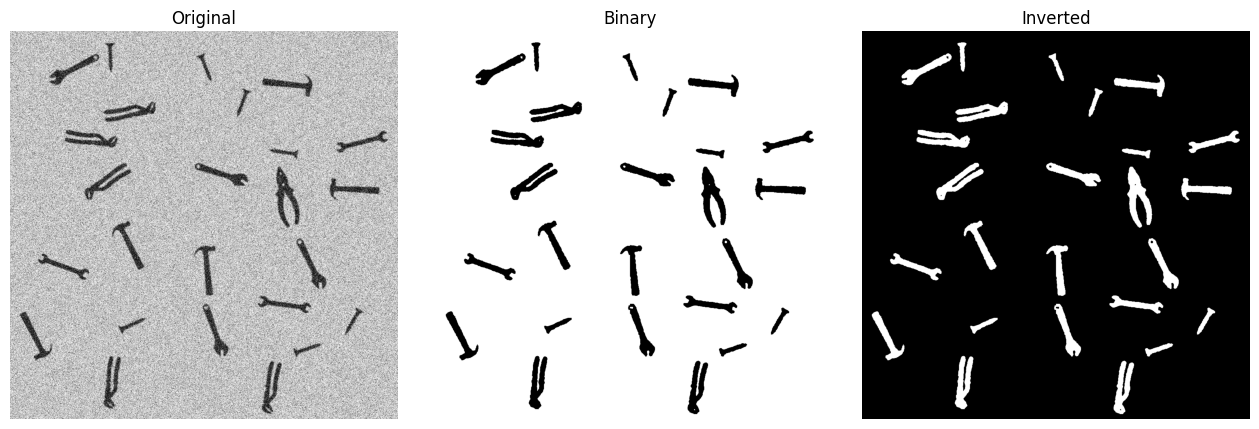

In [31]:
original, bi, final,_ = dynamic_binarization2(r"Evaluation_Images\evaluation_0.png")
show_3figures(original, bi, final, 'Original', 'Binary', 'Inverted')

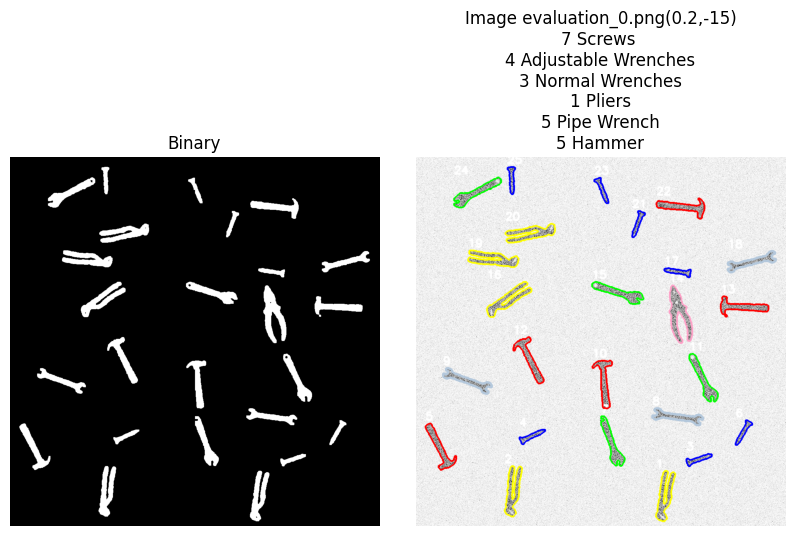

In [32]:
_ = dynamic_binarization2(r"Evaluation_Images\evaluation_0.png",exibir=True)

### **Testes**

#### Robustness against drastic brightness variation

In [ ]:
imagens = glob.glob("Test_Images/*")
img1 = cv.imread(imagens[0])
img2 = cv.imread(imagens[1])
show_2figures(img1,img2,'Brightness: 250','Brightness: 25')

for imagem in imagens:  
    _ = dynamic_binarization2(imagem, exibir=True)

#### Noise Robustness 

In [ ]:
img = cv.imread(r"Evaluation_Images\evaluation_0.png",cv.IMREAD_GRAYSCALE)
noised = cv.imread(r"Test_Images2\evaluation_0_ruido.png",cv.IMREAD_GRAYSCALE)
show_2figures(img,noised,'Original', 'Gaussian Noise(mean=0.4/sigma=100)')

_ = dynamic_binarization2(r"Test_Images2\evaluation_0_ruido.png", exibir=True)


### **Dictionary Data Structure**

In [ ]:
imagens = glob.glob("Evaluation_Images/*")
dictionary = contagens(imagens)
print(json.dumps(dictionary, indent=4, ensure_ascii=False))

# for imagem in imagens:  
#     _ = dynamic_binarization2(imagem,exibir=True)